# Entailment Classification with Graph Matching

In [1]:
import torch
from joint_seq2seq import *
from agnostic_match import *

import warnings, matplotlib
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline

config = {"BATCH_SIZE" : 32,
          "HID_DIM" : 512,
          "N_LAYERS" : 2,
          "ATTN_TYPE" : "luong",
          "ATTN_FUNC" : "dot",
          "DROPOUT" : 0.2}

#### Load data and build vocaulary to set up seq2seq model

In [2]:
# Load pretrained Word2Vec model
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [3]:
paths = [".\snli_1.0_dev.txt", 
         ".\snli_1.0_train.txt"]

multi_train = JointDataset.load_dataset(paths)
len(multi_train)

Loading SNLI dataset.
Loading SNLI dataset.


186743

In [4]:
vocab = Vocabulary.build_vocabulary(multi_train, wv, min_freq=2, n_most_freq=10000)
oov_size = len(vocab.vocabulary) - vocab.pretrained.size(0)


Done!


#### Loading pretrained Seq2Seq 

In [5]:
# set a seed and use a utility function to obtain deterministic results
SEED = 1234
set_all_seeds(SEED)

# use cuda device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"You are using {device} device")

# set up the model with parameters from config
seq2seq = Seq2Seq(oov_size, len(vocab.vocabulary),
                pretrained_w2v = vocab.pretrained,
                hidden_size = config["HID_DIM"],
                n_layers = config["N_LAYERS"],
                dropout = config["DROPOUT"],
                device = device)

# randomly initialize model parameters and move the model to cuda (if available)
seq2seq.apply(init_weights)
seq2seq = seq2seq.to(device)

# select an optimizer and a loss function for training
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)
criterion = nn.NLLLoss(ignore_index = 0)

print(f'The seq2seq model has {count_parameters(seq2seq):,} trainable parameters')
seq2seq

You are using cuda device
The seq2seq model has 19,307,020 trainable parameters


Seq2Seq(
  (pretrained_embedding): Embedding(10000, 300, padding_idx=0)
  (trainable_embedding): Embedding(8812, 300)
  (encoder): EncoderRNN(
    (bilstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): DecoderLuong(
    (attn): GlobalAttention()
    (rnn): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2)
    (proj): Linear(in_features=1024, out_features=512, bias=True)
    (out): Linear(in_features=512, out_features=18812, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

In [6]:
checkpoint = torch.load(r".\checkpoint_Luong_2epochs.tar")
seq2seq.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
seq2seq = seq2seq.to(device)

###  Graph Matching

#### Node encoding with Seq2Seq ENCODER

PREMISE: A guy tries to climb a stone cliff while his friend helps him.
HYPOTHESIS: A person is helping pull someone else up a cliff.

Encoded with Seq2Seq model:

Graph matching:
 ['is helping -> helps', 'a person -> his friend', 'pull -> to climb', 'someone -> him', 'a cliff -> a stone cliff', 'NULL -> NILL']
Similarity Scores: [0.571 0.5   0.286 0.25  0.8   0.   ]

Embedding matching:
 ['a person -> a guy', 'is helping -> tries', 'else -> while', 'someone -> a stone cliff', 'pull -> to climb', 'a cliff -> a stone cliff']
Similarity Scores: [0.478 0.451 0.198 0.278 0.274 0.754]

Semantically related terms: {('pull', 'climb')}
Possible Inference: {('person', 'guy'), ('else', 'while'), ('help', 'try'), ('someone', 'cliff')}
Estimate for syntactic subsumption: 0.625
Estimate for lexical semantics: 0.167
Estimate for high order inference 0.5


(None, None)

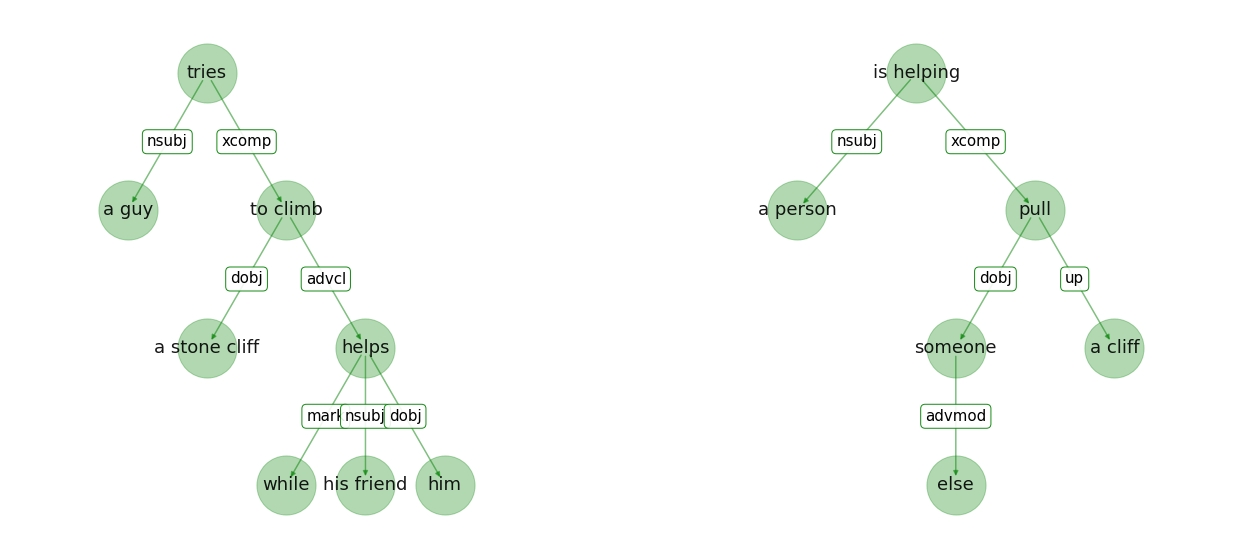

In [22]:
prem, hypo = multi_train[790] 
print("PREMISE:", prem)
print("HYPOTHESIS:", hypo)

# -----------------------------------------------------------------------------------
g_p,_,emb_p = build_graph_and_embed(prem, encode_with_seq2seq, seq2seq, vocab, device)
g_h,_,emb_h = build_graph_and_embed(hypo, encode_with_seq2seq, seq2seq, vocab, device)
m = GraphMatch(g_p, g_h)

m.graph_match() 
m.embedding_match(emb_p, emb_h)


print("\nEncoded with Seq2Seq model:\n")
print("Graph matching:\n", list(f"{node['text']} -> {image['text']}" if not isinstance(node, str) else f"{node} -> {image}"\
                                for (node, image) in m.mapping ))
print("Similarity Scores:", m.scores_array)
print()

print("Embedding matching:\n", list(f"{node['text']} -> {image['text']}" for (node, image) in m.embedding_mapping))
print("Similarity Scores:", m.embedding_scores)
print()

related_nodes = classify_entailment( m.mapping, m.embedding_mapping, g_p, g_h)

# draw syntactic trees of premise(left) and hypothesis(right)
fig, axs = plt.subplots(1, 2, figsize=(22, 10))
draw_graph(g_p, axs[0]), draw_graph(g_h, axs[1])

#### Node encoding with Transformer ENCODER

In [21]:


g_p,_,emb_p = build_graph_and_embed(prem, encode_with_transformer, model, tokenizer, device)
g_h,_,emb_h = build_graph_and_embed(hypo, encode_with_transformer, model, tokenizer, device)

m = GraphMatch(g_p, g_h)
m.graph_match() 
m.embedding_match(emb_p, emb_h)

print("\nEncoded with Transformer model:\n")
print("Graph matching:\n", list(f"{node['text']} -> {image['text']}" if not isinstance(node, str) else f"{node} -> {image}"\
                                for (node, image) in m.mapping ))
print("Similarity Scores:", m.scores_array)
print()

print("Embedding matching:\n", list(f"{node['text']} -> {image['text']}" for (node, image) in m.embedding_mapping))
print("Similarity Scores:", m.embedding_scores)
print()

related_nodes = classify_entailment(m.mapping, m.embedding_mapping, g_p, g_h)


Encoded with Transformer model:

Graph matching:
 ['is helping -> helps', 'a person -> his friend', 'pull -> to climb', 'someone -> him', 'a cliff -> a stone cliff', 'NULL -> NILL']
Similarity Scores: [0.571 0.5   0.286 0.25  0.8   0.   ]

Embedding matching:
 ['a person -> a guy', 'is helping -> tries', 'else -> his friend', 'someone -> his friend', 'pull -> to climb', 'a cliff -> a stone cliff']
Similarity Scores: [0.863 0.621 0.498 0.513 0.642 0.794]

Semantically related terms: {('pull', 'climb')}
Possible Inference: {('person', 'guy'), ('else', 'friend'), ('help', 'try'), ('someone', 'friend')}
Estimate for syntactic subsumption: 0.625
Estimate for lexical semantics: 0.167
Estimate for high order inference 0.5
